In [2]:
try:
  import dolfin
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
  import dolfin

--2024-11-10 23:40:15--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4164 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.07K  --.-KB/s    in 0s      

2024-11-10 23:40:15 (35.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [4164/4164]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/7b6613c7/releases/pybind11-ins

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import subprocess
import os

# --------------------
# Geometry
# --------------------

def convert_mesh_to_xml(mesh_file, xml_file):
    command = f"dolfin-convert {mesh_file} {xml_file}"
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

input_mesh = "/content/drive/MyDrive/TCC/TCC/mesh_1_atualizada.msh" # inserir local que a malha está salva
output_xml = "/content/drive/MyDrive/TCC/TCC/mesh_1_atualizada.xml" # inserir local onde irá salvar malha convertida

convert_mesh_to_xml(input_mesh, output_xml)

In [5]:
import fenics as fe
from fenics import *
import os

# Diretório de saída no Google Drive
output_dir = "/content/drive/MyDrive/TCC/TCC/output"
os.makedirs(output_dir, exist_ok=True)  # Cria a pasta se ela não existir

# Geometria - comprimento e seção da viga
L = 0.1  # Comprimento da viga em metros (100 mm)
W = 0.004  # Lado da seção quadrada da viga (10 mm)

# Parâmetros do problema
E = 197e9  # Módulo de Young (Pa)
nu = 0.29   # Coeficiente de Poisson

# Constantes de Lamé
mu = E / (2 * (1 + nu))  # Módulo de cisalhamento (segunda constante de Lamé)
lambda_ = (E * nu) / ((1 + nu) * (1 - 2 * nu))  # Primeira constante de Lamé

# Definir a força externa total (em Newtons)
F_total = 10.0  # Força total em Newtons

# Carregar a malha e a função de regiões
xml_file = "/content/drive/MyDrive/TCC/TCC/mesh_1_atualizada.xml"  # Atualize o caminho do arquivo da malha
facet_region_file = "/content/drive/MyDrive/TCC/TCC/mesh_1_atualizada_facet_region.xml"  # Atualize o caminho do arquivo de região
mesh = fe.Mesh(xml_file)
fd = fe.MeshFunction('size_t', mesh, facet_region_file)

# Espaço de funções
V = VectorFunctionSpace(mesh, 'Lagrange', 1)

# Definir a condição de contorno - apoio à esquerda (fd = 1)
bc = DirichletBC(V, Constant((0, 0, 0)), fd, 1)

# Definir o tensor de deformação (strain) e o tensor de tensões (stress)
def epsilon(u):
    return 0.5 * (nabla_grad(u) + nabla_grad(u).T)

def sigma(u):
    return lambda_ * div(u) * Identity(u.geometric_dimension()) + 2 * mu * epsilon(u)

# Definir a força externa distribuída no contorno à direita (fd = 2)
f = Constant((0, 0, -F_total / (W * W)))  # Força distribuída por unidade de área

# Definir o problema variacional
u = TrialFunction(V)
v = TestFunction(V)
d = u.geometric_dimension()  # Dimensão do espaço
ds = Measure('ds', domain=mesh, subdomain_data=fd)
dx = Measure('dx', domain=mesh, subdomain_data=fd)

# Montar a forma fraca
a = inner(sigma(u), epsilon(v)) * dx
L = dot(f, v) * ds(2)  # Força atuando na extremidade direita (fd = 2)

# Resolver o problema
u = Function(V)
solve(a == L, u, bc)

# Exportar resultados para ParaView (formato VTK)

# Arquivo para o deslocamento
vtk_displacement_file = File(os.path.join(output_dir, "displacement.pvd"))
vtk_displacement_file << u

# Calcular tensões
s = sigma(u) - (1./3) * tr(sigma(u)) * Identity(d)  # Tensão desviadora

# Tensão de Von Mises
von_Mises = sqrt(3./2 * inner(s, s))
V_von_Mises = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V_von_Mises)

# Exportar a tensão de Von Mises
vtk_von_mises_file = File(os.path.join(output_dir, "von_mises.pvd"))
vtk_von_mises_file << von_Mises

print(f"Arquivos exportados para {output_dir}")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_d0280b54b788351a9a1c721dfa1d7a2c33a1e4f4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00892138 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.570656 seconds.

INFO:FFC:Compiler stage 3

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cdd21d347a8b939a40c5cd04a75bdb0e0e4b85cb

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00336337 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0160091 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5c1842af1a36e5ba8ade5a839374d2f69a7a58c7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of exterior_facet subdomains: 3
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              1
  Coefficients:                        '[f_8]'
  Unique elements:                     'Vector<3 x CG1(?,?)>, Vector<3 x R0(?,?)>'
  Unique sub elements:                 'Vector<3 x CG1(?,?)>, Vector<3 x 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e6926685f1f34f2dec492a87687d37f7a8b0bd63

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00315595 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0140047 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_86b746b496d889301d763f3268d8f3175411960f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00764728 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0154676 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_a0966de4b5a0936f94b2b6216e0175efa637330c

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00780606 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.015115 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_882e9e1744162fb8f3c69eaa02177d1be6c361b6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<3 x CG1(?,?)>'
  Unique sub elements:       'Vector<3 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.152648 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ba3ac0f37dd5c2d22a91969a353e2effd0351f24

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0270851 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_034616a025277419a92e7b98f5872000d114fcb8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00371361 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0226314 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e56f626fb8a3283a24be8e9c28b33f1893ee0e38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00489926 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0189042 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_b6c7c5ddd0807e95591ada59c5293d430d44e4dd

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00521111 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0108836 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_de8fa195de657162b83c64d27d0dea508abcb329

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_9]'
  Unique elements:           'CG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0483441 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------

Arquivos exportados para /content/drive/MyDrive/TCC/TCC/output


In [6]:
L_total = float(0.1)
sol_num = -u(L_total,0,0)[2]*1e6
print("Deflexão máxima pelo MEF:", sol_num,"micrometros")
I = W**4/12
sol_anal = float(F_total*(L_total**3)/(3*E*I))*1e6
print("Deflexão máxima teórica:", sol_anal,"micrometros")
print("Erro relativo:", abs(sol_num - sol_anal)*100 / sol_anal,"%")

Deflexão máxima pelo MEF: 779.1633566207138 micrometros
Deflexão máxima teórica: 793.1472081218274 micrometros
Erro relativo: 1.7630839972604 %


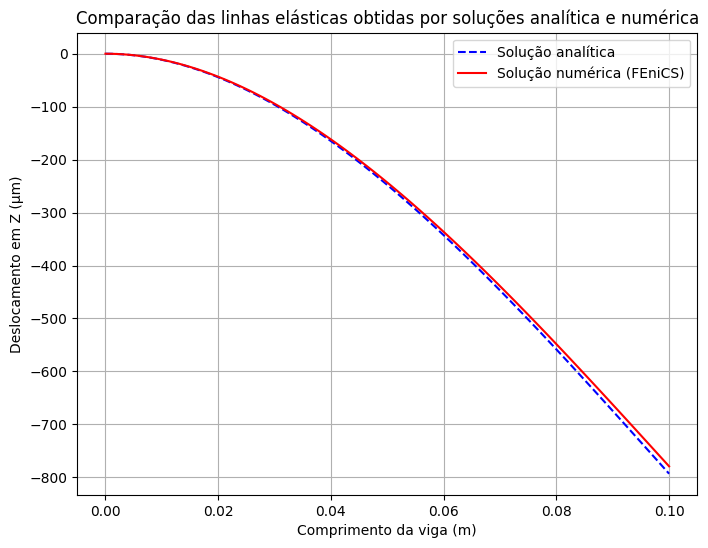

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Função para o deslocamento analítico
def displacement_analytic(x, L, E, I, F):
    return (-F * x**2 * (3 * L - x)) / (6 * E * I)

# Pontos ao longo do comprimento da viga
x_vals = np.linspace(0, L_total, 100)
w_analytic = displacement_analytic(x_vals, L_total, E, I, F_total)

# Solução numérica do Fenics (exemplo: valores ao longo de x)
# Suponha que a solução numérica foi projetada nos pontos de malha e obtemos u_num (deslocamento numérico)
u_num = np.array([u(x,0,0)[2]*1e6 for x in x_vals])  # Assumindo que u(x) é a solução numérica obtida com Fenics

# Plotar as soluções
plt.figure(figsize=(8, 6))
plt.plot(x_vals, w_analytic*1e6, label="Solução analítica", linestyle="--", color="blue")
plt.plot(x_vals, u_num, label="Solução numérica (FEniCS)", linestyle="-", color="red")
plt.xlabel('Comprimento da viga (m)')
plt.ylabel('Deslocamento em Z (µm)')
plt.title('Comparação das linhas elásticas obtidas por soluções analítica e numérica')
plt.legend()
plt.grid(True)
plt.show()
